In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import requests
from datetime import timedelta
import os
import matplotlib as mpl

%config InlineBackend.figure_format = 'png'

# Covid-19 in Nederland

Dit notebook toont het aantal Covid-19 besmettingen in Nederland, en fit hier een exponentiële en logistische functie aan.

Let op: 
- Deze grafiek is niet door een expert gemaakt, deze informatie is niet beter dan de informatie waar het RIVM over beschikt.
- Het verspreidingspatroon van een virus volgt alleen in de beginstadia een exponentiële functie.
- Effecten van meer/betere tests, betere voorlichting, etc. hebben invloed op de verspreiding, deze worden _niet_ meegenomen.
- Het RIVM test gezinsleden van besmette mensen (meestal) niet. Mogelijk deden ze dat eerder wel.
- 3.9% van de ziekenhuismedewerkers in Brabant is besmet ([blijkt uit steekproef](https://www.rivm.nl/nieuws/resultaat-steekproef-4-ziekenhuismedewerkers-heeft-coronavirus)). In het Radboud alleen al werken 11k mensen.

Nuancering:

<img src="https://imgs.xkcd.com/comics/extrapolating.png" alt="curve-fit" width="300"/>

(bron: [xkcd 605](https://xkcd.com/605/))

## Useful links

- Epidemic calculator: http://gabgoh.github.io/COVID/index.html
- Epidemic calculator with different scenario's: https://neherlab.org/covid19/
- Worldwide numberes on Corona: https://www.worldometers.info/coronavirus/
- Overview on open source Corona-related projects: https://github.com/soroushchehresa/awesome-coronavirus

## Opinions and background articles
- [Coronavirus: The Hammer and The Dance](https://medium.com/@tomaspueyo/coronavirus-the-hammer-and-the-dance-be9337092b56)
- [Coronavirus in Deutschland - Alle bestätigten Fälle auf einer Karte (German)](https://www.zeit.de/wissen/gesundheit/2020-03/coronavirus-deutschland-infektionen-faelle-verbreitung-epidemie-karte)

## Datasets

### Netherlands

Data sources:
- [RIVM](https://www.rivm.nl/nieuws/actuele-informatie-over-coronavirus) - updated daily at 14:00
- [Nationale Intensive Care Evaluatie](https://stichting-nice.nl) - updated dynamically

In [2]:
def get_nl_data():
    df_nl = pd.read_csv('data/nl.csv', index_col=0)
    df_nl.index = pd.to_datetime(df_nl.index)

    # Get current IC cases
    df_icu = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-count/')
    df_icu.date = pd.to_datetime(df_icu.date)
    df_icu.set_index('date', inplace=True)
    df_icu.index = df_icu.index + timedelta(hours=14)
    df_nl['current_icu'] = df_icu['intakeCount']

    # Get cumulative IC cases
    df_icu = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-cumulative/')
    df_icu.date = pd.to_datetime(df_icu.date)
    df_icu.set_index('date', inplace=True)
    df_icu.index = df_icu.index + timedelta(hours=14)
    df_nl['hospitalized_icu'] = df_icu['intakeCumulative']
    
    # Calculate cumulative non-IC cases (not directly available)
    df_nl['hospitalized_without_icu'] = df_nl['hospitalized_cases'] - df_nl['hospitalized_icu']
    
    # Calculate new cases
    df_nl['new_cases'] = df_nl['cumulative_cases'].diff().fillna(0)
    
    return df_nl

In [3]:
df_netherlands = get_nl_data()
print(f'{df_netherlands.shape[0]} days, from {df_netherlands.index.min()} to {df_netherlands.index.max()}')
df_netherlands.tail(1)

25 days, from 2020-02-27 14:00:00 to 2020-03-22 14:00:00


cumulative_cases  deaths  hospitalized_cases  \
2020-03-22 14:00:00              4204   179.0               988.0   

                     current_icu  hospitalized_icu  hospitalized_without_icu  \
2020-03-22 14:00:00        341.0             386.0                     602.0   

                     new_cases  
2020-03-22 14:00:00      573.0

### Italy

Data sources:
- [Italian government](http://www.salute.gov.it/portale/news/p3_2_0.jsp?lingua=italiano&id=1285) - updated daily at 18:00
- [csv version](https://github.com/pcm-dpc/COVID-19) in `pcm-dpc/COVID-19` github repository.



In [10]:
def load_italy():
    df_italy = pd.concat([
        pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'),
        pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv')
    ]).drop_duplicates()
        
    df_italy.rename(columns={
        'data': 'date',
        'stato': 'country', 
        'ricoverati_con_sintomi': 'hospitalized_without_icu',
        'terapia_intensiva': 'hospitalized_icu',
        'totale_ospedalizzati': 'hospitalized_cases',
        'isolamento_domiciliare': 'patients_quarantined',
        'totale_attualmente_positivi': 'current_cases',
        'nuovi_attualmente_positivi': 'new_cases',
        'dimessi_guariti': 'recovered',
        'deceduti': 'deaths',
        'totale_casi': 'cumulative_cases',
        'tamponi': 'performed_tests',
    }, inplace=True)
    del df_italy['country']
    df_italy['current_icu'] = df_italy['hospitalized_icu']
    df_italy['current_non_icu'] = df_italy['hospitalized_without_icu']
    df_italy.date = pd.to_datetime(df_italy.date)
    df_italy.set_index('date', inplace=True)
    return df_italy

In [11]:
df_italy = load_italy()
print(f'{df_italy.shape[0]} days, from {df_italy.index.min()} to {df_italy.index.max()}')
df_italy.tail(1)

28 days, from 2020-02-24 18:00:00 to 2020-03-22 17:00:00


hospitalized_without_icu  hospitalized_icu  \
date                                                              
2020-03-22 17:00:00                     19846              3009   

                     hospitalized_cases  patients_quarantined  current_cases  \
date                                                                           
2020-03-22 17:00:00               22855                 23783          46638   

                     new_cases  recovered  deaths  cumulative_cases  \
date                                                                  
2020-03-22 17:00:00       3957       7024    5476             59138   

                     performed_tests  current_icu  current_non_icu  
date                                                                
2020-03-22 17:00:00           258402         3009            19846

## Visualization

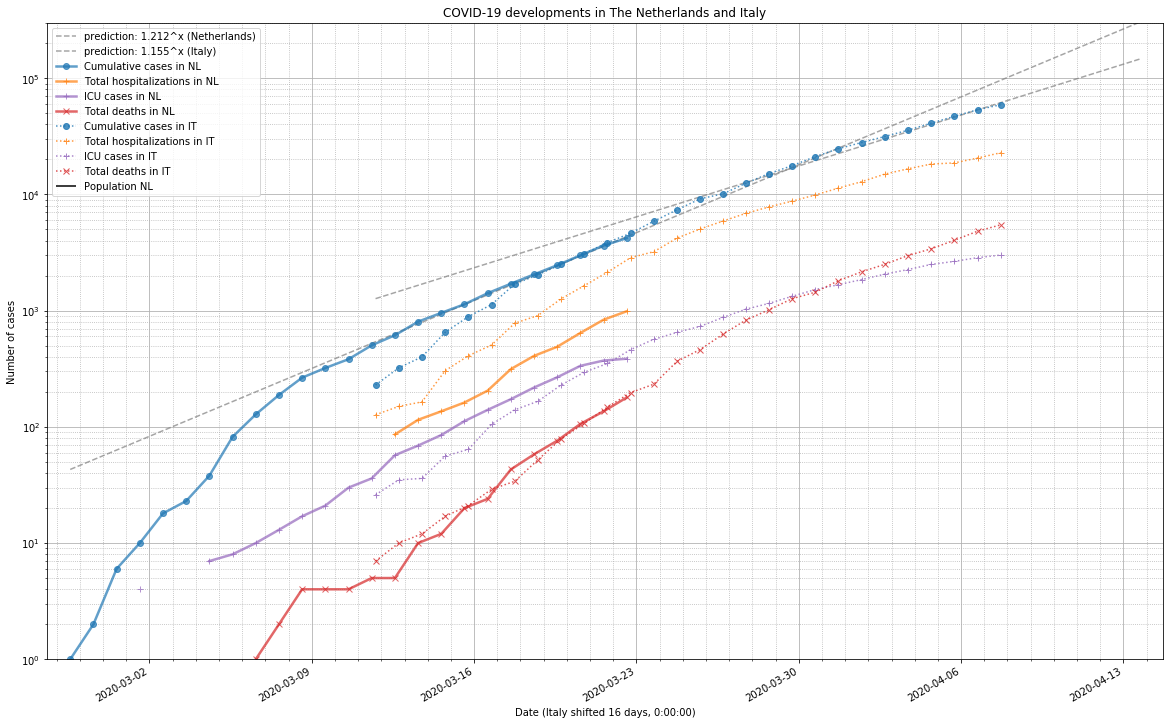

In [13]:
def fit_prediction(df, max_date, kind='exponential', offset=None):
    def exp_func(x, a, b):
        return b ** (x - a)


    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    if offset:
        df = df.copy()
        df.index = df.index + offset

    [a, b], _ = curve_fit(exp_func, np.arange(len(df.cumulative_cases[:])), df.cumulative_cases[:])
    [L, k, x0], _ = curve_fit(
        logistic_func, np.arange(len(df.cumulative_cases)), df.cumulative_cases, p0=[1e4, 0.3, 30]
    )
    [k_, x0_], _ = curve_fit(
        lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
        np.arange(len(df.cumulative_cases)),
        df.cumulative_cases,
        p0=[0.3, 30],
    )

    date_index = pd.date_range(start=df.index.min(), end=max_date, freq="D",)    
    y_pred_exp = exp_func(np.arange(len(date_index)), a, b)
    y_pred_logistic = logistic_func(np.arange(len(date_index)), L, k, x0)

    
    label = ''
    if kind == 'exponential':
        curve = pd.Series(index=date_index, data=y_pred_exp)
        label = f"prediction: {b.round(3)}^x"
    elif kind == 'logistic':
        curve = pd.Series(index=date_index, data=y_pred_logistic)
        label = f"Prediction: logistic function (conv. -> {L.round(1)})"
    else:
        raise Error(f'Unknown kind: {kind}')
    
    return curve, label
    



def plot_prediction(ax, series, **kwargs):
    series.plot(ax=ax, c='C7', alpha=.7, lw=1.5, style='--', **kwargs)
    

def plot_situation(ax, df, offset=None, country='', **kwargs):
    if offset:
        df = df.copy()
        df.index = df.index + offset
    
    kwargs = {
        "alpha": .8,
        **kwargs
    }
    
    
    df.cumulative_cases.plot(label=f"Cumulative cases in {country}", marker="o", c='C0', ax=ax, **kwargs)
    df.hospitalized_cases.plot(label=f"Total hospitalizations in {country}", marker="+", c='C1', ax=ax, **kwargs)
    df.hospitalized_icu.plot(label=f"ICU cases in {country}", marker="+", c='C4', ax=ax, **kwargs)
    df.deaths.plot(label=f"Total deaths in {country}", marker="x", c='C3', ax=ax, **kwargs)
    


# plt.style.reload_library()
# plt.style.use('seaborn-notebook')

fig, ax = plt.subplots(figsize=(20,13))

offset_italy = timedelta(days=16)
min_date = np.min([df_netherlands.index.min(), df_italy.index.min() + offset_italy]) - timedelta(days=1)
max_date = np.max([df_netherlands.index.max(), df_italy.index.max() + offset_italy]) + timedelta(days=7)

curve, label = fit_prediction(df_netherlands, max_date=max_date)
plot_prediction(ax, curve, label=f'{label} (Netherlands)')
curve, label = fit_prediction(df_italy, max_date=max_date, offset=offset_italy)
plot_prediction(ax, curve, label=f'{label} (Italy)')

plot_situation(ax, df_netherlands, country='NL', lw=2.5, alpha=.7)
plot_situation(ax, df_italy, offset=offset_italy, country='IT', style=':')


ax.hlines(17.4e6, min_date, max_date, label="Population NL")



ax.set_yscale("log")

ax.set_ylim([1, 3e5])
ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f'Date (Italy shifted {offset_italy})')
ax.set_ylabel('Number of cases')
ax.set_title('COVID-19 developments in The Netherlands and Italy')
fig.autofmt_xdate()

ax.legend(loc=2)

### ICU in NL and IT

Dutch ICU capacity based on [](https://www.rtlnieuws.nl/nieuws/nederland/artikel/5063091/corona-ic-capaciteit-intensive-care-diederik-gommers-nvic)

Source for hospital beds: https://www.euronews.com/2020/03/19/covid-19-how-many-intensive-care-beds-do-member-states-have

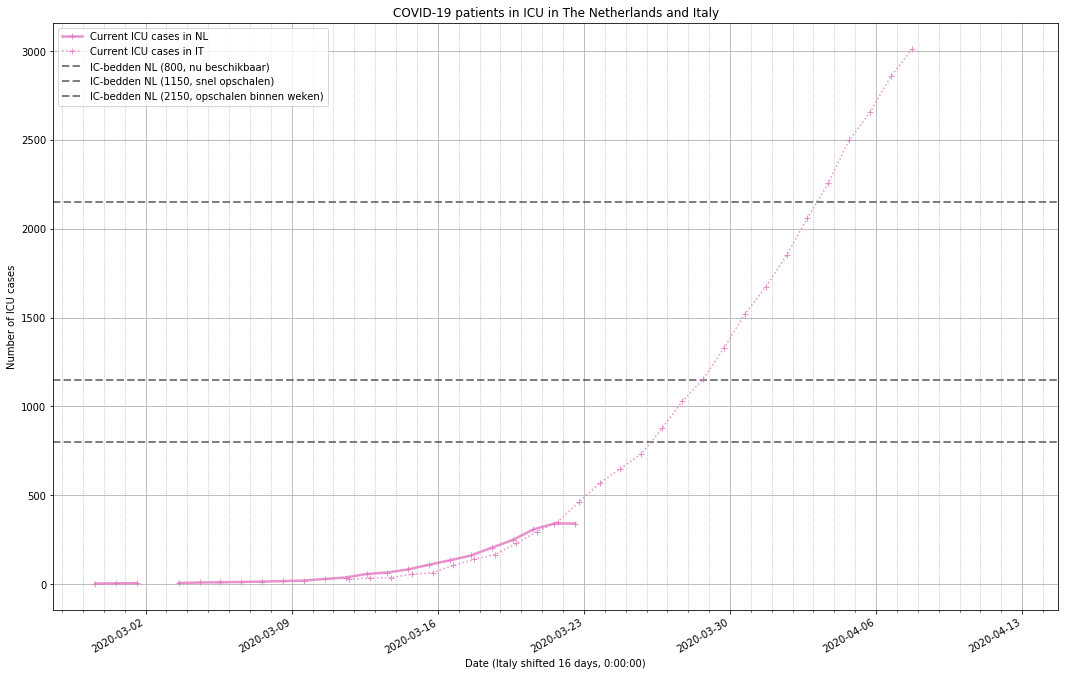

In [14]:
def plot_icu(ax, df, offset=None, country='', **kwargs):
    if offset:
        df = df.copy()
        df.index = df.index + offset
    
    kwargs = {
        "alpha": .8,
        **kwargs
    }
    
    
    df.current_icu.plot(label=f"Current ICU cases in {country}", marker="+", ax=ax, c='C6', **kwargs)
#     df.deaths.plot(label=f"Total deaths in {country}", marker="x", ax=ax, **kwargs)
    


# plt.style.reload_library()
# plt.style.use('seaborn-notebook')

fig, ax = plt.subplots(figsize=(18,12))

offset_italy = timedelta(days=16)
min_date = np.min([df_netherlands.index.min(), df_italy.index.min() + offset_italy]) - timedelta(days=1)
max_date = np.max([df_netherlands.index.max(), df_italy.index.max() + offset_italy]) + timedelta(days=7)

plot_icu(ax, df_netherlands, country='NL', lw=2.5)
plot_icu(ax, df_italy, offset=offset_italy, country='IT', style=':')


ax.hlines(1150-350, min_date, max_date, label="IC-bedden NL (800, nu beschikbaar)", lw=2, alpha=.5, linestyle='--')
ax.hlines(1500-350, min_date, max_date, label="IC-bedden NL (1150, snel opschalen)", lw=2, alpha=.5, linestyle='--')
ax.hlines(2500-350, min_date, max_date, label="IC-bedden NL (2150, opschalen binnen weken)", lw=2, alpha=.5, linestyle='--')

# ax.set_yscale("log")

# ax.set_ylim([1, 3e4])
ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f'Date (Italy shifted {offset_italy})')
ax.set_ylabel('Number of ICU cases')
ax.set_title('COVID-19 patients in ICU in The Netherlands and Italy')
fig.autofmt_xdate()

ax.legend(loc=2)

### Trend development

Visualisation of the trends in total cases, ICU cases and deaths. We fit an exponential function on a floating window of 7 days.

(<Figure size 1872x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1243b2490>)

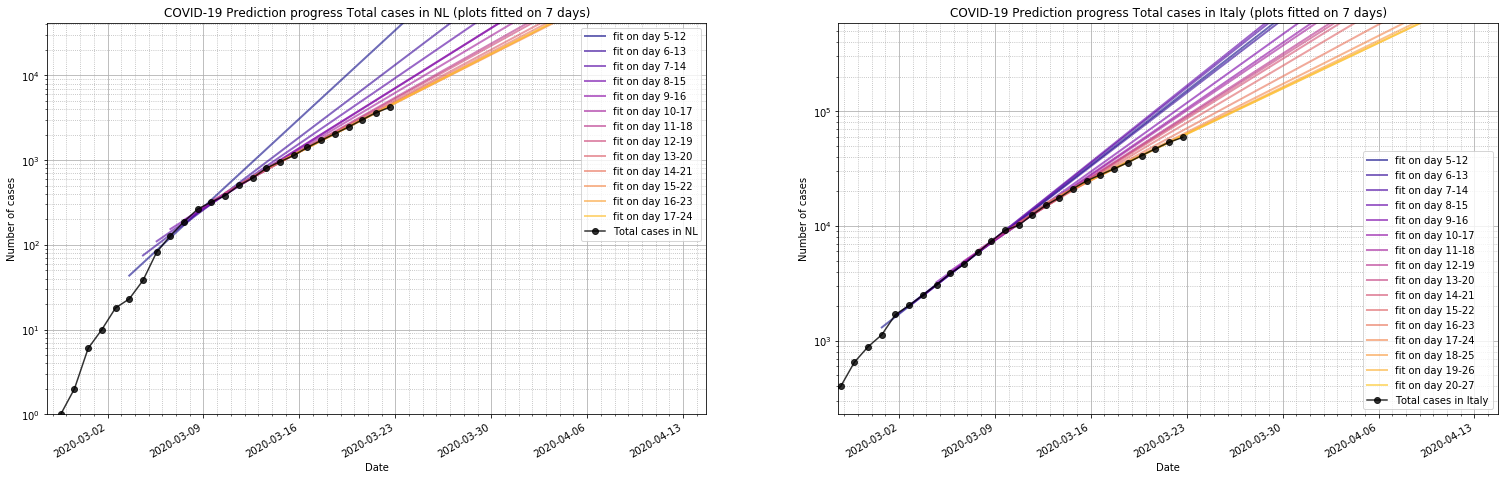

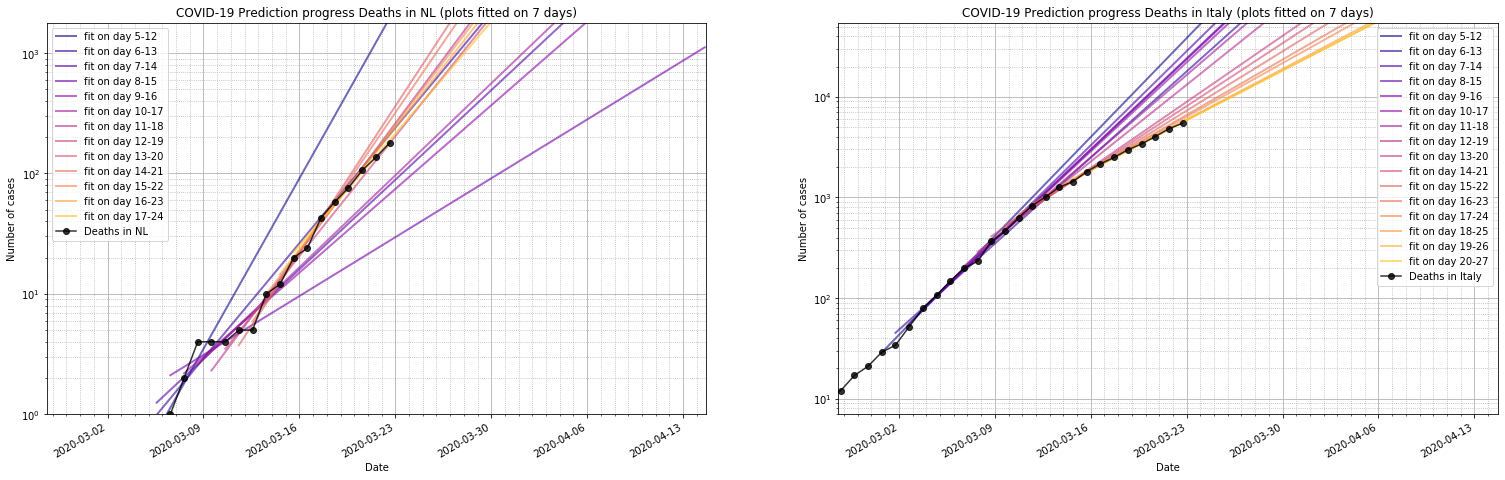

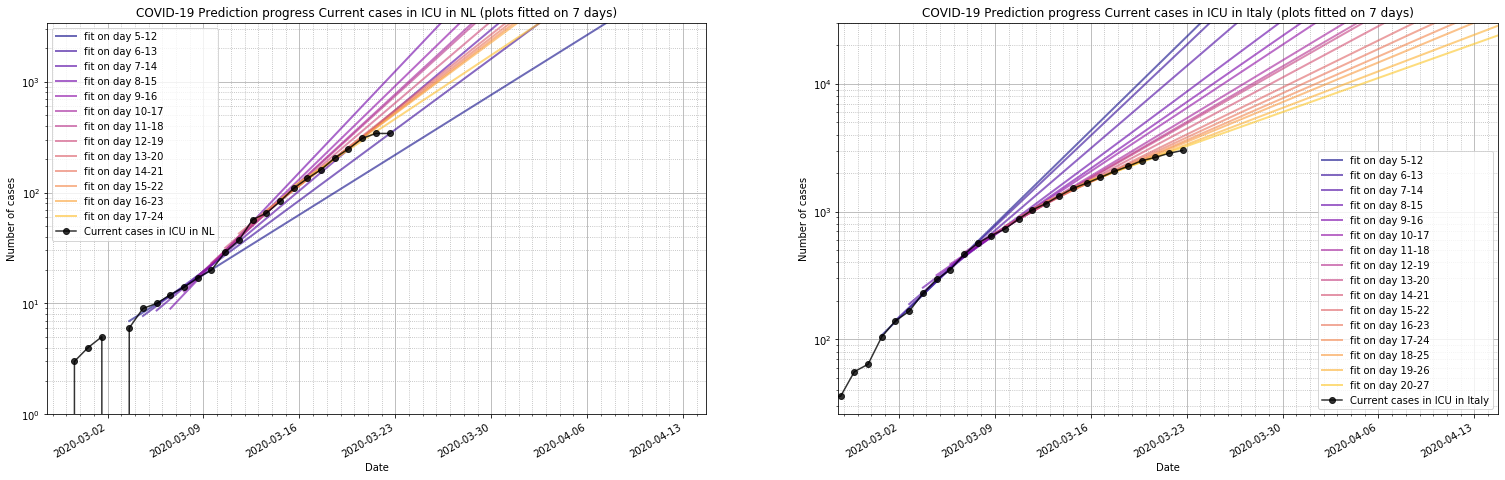

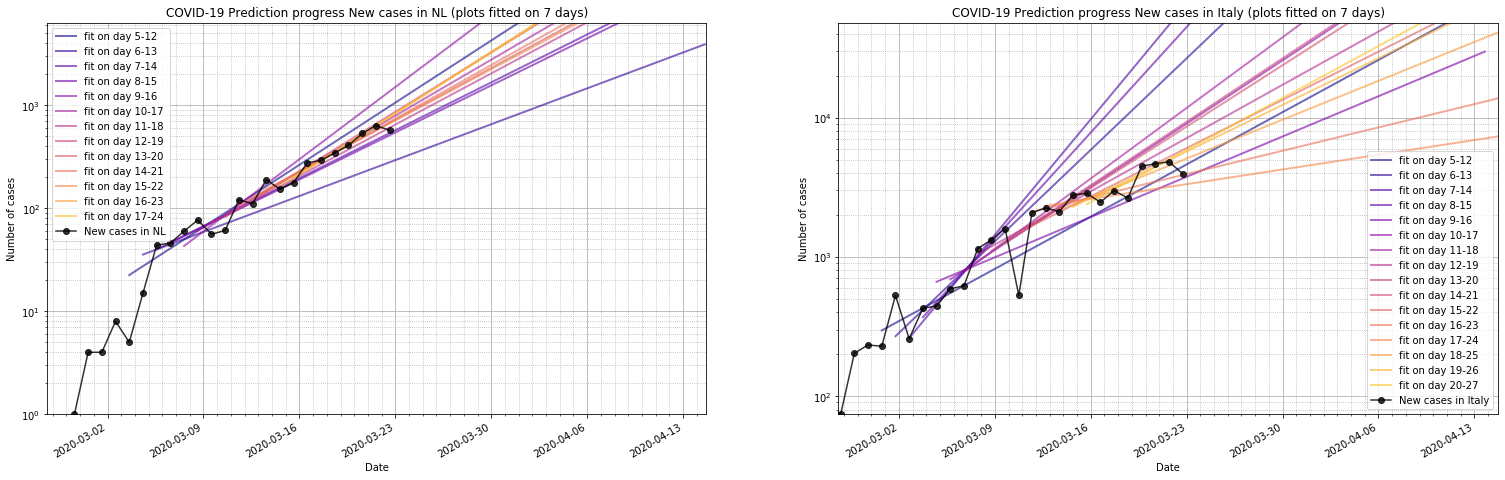

In [15]:
def fit_prediction(series, max_date, kind='exponential', offset=None):
    def exp_func(x, a, b):
        return b ** (x - a)


    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    [a, b], _ = curve_fit(exp_func, np.arange(len(series[:])), series[:].fillna(0))
#     [L, k, x0], _ = curve_fit(
#         logistic_func, np.arange(len(df.cumulative_cases)), df.cumulative_cases, p0=[1e4, 0.3, 30]
#     )
    [k_, x0_], _ = curve_fit(
        lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
        np.arange(len(series)),
        series,
        p0=[0.3, 30],
    )

    date_index = pd.date_range(start=series.index.min(), end=max_date, freq="D",)    
    y_pred_exp = exp_func(np.arange(len(date_index)), a, b)
#     y_pred_logistic = logistic_func(np.arange(len(date_index)), L, k, x0)

    
    label = ''
    if kind == 'exponential':
        curve = pd.Series(index=date_index, data=y_pred_exp)
        label = f"prediction: {b.round(3)}^x"
    elif kind == 'logistic':
        curve = pd.Series(index=date_index, data=y_pred_logistic)
        label = f"Prediction: logistic function (conv. -> {L.round(1)})"
    else:
        raise Error(f'Unknown kind: {kind}')
    
    return curve, label


# plt.style.reload_library()
# plt.style.use('seaborn-notebook')


offset_italy = timedelta(days=16)
min_date = np.min([df_netherlands.index.min(), df_italy.index.min() + offset_italy]) - timedelta(days=1)
max_date = np.max([df_netherlands.index.max(), df_italy.index.max() + offset_italy]) + timedelta(days=7)

# for i in range(7, len(df_netherlands)):
#     curve, label = fit_prediction(df_netherlands[i-7:i], max_date=max_date)
#     curve.plot(ax=ax, c='C4', lw=1.6, alpha=.2+.3*i/len(df_netherlands))

def plot_trend_development(series, title, max_date, days=7, offset=None, skip_days=5, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(15,8))
    else:
        fig = ax.get_figure()

    series = series.copy()
    series = series.fillna(0)
    if offset:        
        series.index = series.index + offset
    cmap = mpl.cm.get_cmap('plasma', len(series) + 2 - skip_days - days)

    for i in range(days + skip_days, len(series)):
        curve, label = fit_prediction(series[i-days:i], max_date=max_date)
        curve.plot(ax=ax,  lw=2, alpha=.6, c=cmap(i-days-skip_days), label=f'fit on day {i-days}-{i}')
        
    series.plot(label=title, marker="o", c='k', ax=ax, alpha=.8)

    ax.set_yscale("log")

    ax.set_ylim(np.max([series.min(), 1]), 10*series.max())
    ax.set_xlim(min_date, max_date)

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.grid(which="minor", linestyle=(":"))
    ax.grid(which="major")
    ax.set_xlabel(f'Date')
    ax.set_ylabel('Number of cases')
    ax.set_title(f'COVID-19 Prediction progress {title} (plots fitted on {days} days)')
    fig.autofmt_xdate()
    ax.legend()
    return fig, ax

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(df_netherlands.cumulative_cases, 'Total cases in NL', max_date, ax=axes[0])
plot_trend_development(df_italy.cumulative_cases, 'Total cases in Italy', max_date, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(df_netherlands.deaths, 'Deaths in NL', max_date, ax=axes[0])
plot_trend_development(df_italy.deaths, 'Deaths in Italy', max_date, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(df_netherlands.current_icu, 'Current cases in ICU in NL', max_date, ax=axes[0])
plot_trend_development(df_italy.current_icu, 'Current cases in ICU in Italy', max_date, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(df_netherlands.new_cases, 'New cases in NL', max_date, ax=axes[0])
plot_trend_development(df_italy.new_cases, 'New cases in Italy', max_date, ax=axes[1])




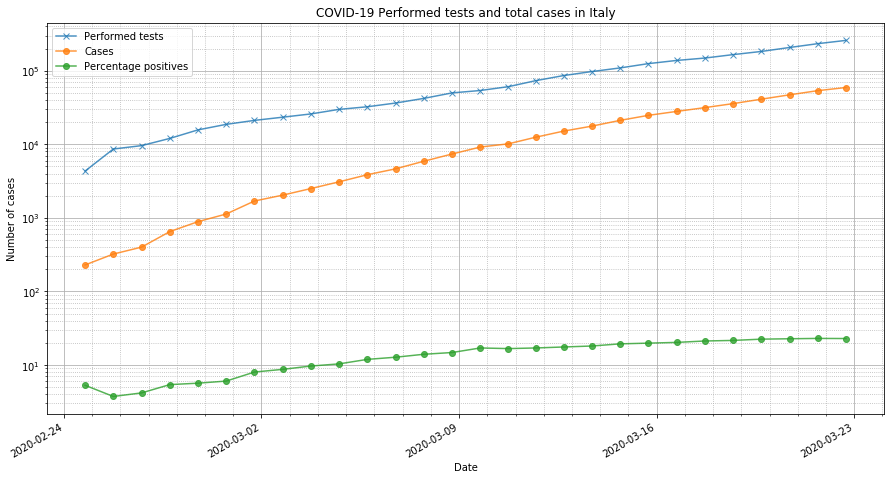

In [16]:
fig, ax = plt.subplots(figsize=(15,8))


df_italy.performed_tests.plot(label="Performed tests", marker="x", ax=ax, alpha=.8)

df_italy.cumulative_cases.plot(label="Cases", marker="o", ax=ax, alpha=.8)

(100*df_italy.cumulative_cases/df_italy.performed_tests).plot(label="Percentage positives", marker="o", ax=ax, alpha=.8)


ax.set_yscale("log")

# ax.set_ylim(1, 10*df_italy.performed_tests.max())
# ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f'Date')
ax.set_ylabel('Number of cases')
ax.set_title(f'COVID-19 Performed tests and total cases in Italy')
fig.autofmt_xdate()
ax.legend()

In [191]:
assert(not os.path.isfile('data/nl.csv'))
# Produce NL dataset as csv. Last updated: 21 march 2020

# fmt:off
besmettingen = np.array(
    [1, 2, 6, 10, 18, 23, 38, 82, 128, 188, 265, 321, 382, 503, 614, 804, 957,
     1135, 1413, 1705, 2051, 2460, 2994, 3631]
)
# fmt:on
schattingen = np.array([np.nan] * 17 + [6000])

sterfgevallen = np.array(
    [np.nan] * 8 + [1, 2, 4, 4, 4, 5, 5, 10, 12, 20, 24, 43, 58, 76, 106, 136]
)
ziekenhuisopnames = np.array(
    [np.nan] * 14 + [86, 115, 136, 162, 205, 314, 408, 489, 643, 836]
)

besmettingen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(besmettingen), freq="D"),
    data=besmettingen,
    name="besmettingen",
)
schattingen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(schattingen), freq="D"),
    data=schattingen,
    name="schatting",
)
ziekenhuisopnames = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(ziekenhuisopnames), freq="D"),
    data=ziekenhuisopnames,
    name="schatting",
)
sterfgevallen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(sterfgevallen), freq="D"),
    data=sterfgevallen,
    name="sterfgevallen",
)

df_nl = pd.DataFrame({
    "cumulative_cases": besmettingen,
    "deaths": sterfgevallen,
    "hospitalized_cases": ziekenhuisopnames,
})
df_nl.index = df_nl.index + timedelta(hours=14)
df_nl.to_csv('data/nl.csv')

AssertionError: 

---
old

In [74]:
# fmt:off
# italie_besmet = np.array(
#     [3, 3, 3, 3, 3, 4, 21, 79, 157, 229, 323, 470, 655, 889, 1128, 1701,
#      2036, 2502, 3089, 3858, 4636, 5883, 7375, 9172, 10149, 12462, 15113, 21157, 24747, 27980] + 20 * [np.nan]
# )
italie_besmet = np.concatenate([df_italy.total_cases.values, np.array(20 * [np.nan])])

# italie_sterf = np.array(
#     [np.nan] * 6 + [1, 2, 3, 7, 11, 12, 17, 21, 29, 41,
#      52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1441, 1809, 2158] + 20 * [np.nan]
# )
italie_sterf = np.concatenate([df_italy.deaths.values, np.array(20 * [np.nan])])



# italie_ziekenhuis = np.array(
# [np.nan] * 13 + [345, 401, 639, 742, 1034] + [np.nan]* 4 + [2651, 3557, 4316, 5038, 5838, 6650, 7426, 8372, 9663, 11025, 12894, 14363] + 20 * [np.nan]
# )
italie_ziekenhuis = np.concatenate([df_italy.hospitalized_without_icu.values, np.array(20 * [np.nan])])



# italie_ic = np.array(
#     [np.nan] * 13 + [64, 105, 140, 166, 229] + [np.nan]* 4 + [567, 650, 733, 877, 1028, 1153, 1328, 1518, 1672, 1851, 2060, 2257] + 20 * [np.nan]
# )
italie_ic = np.concatenate([df_italy.hospitalized_icu.values, np.array(20 * [np.nan])])




# fmt:on

italie_besmet = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_besmet), freq="D"),
    data=italie_besmet,
)
italie_sterf = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_sterf), freq="D"),
    data=italie_sterf,
)

italie_ziekenhuis = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_ziekenhuis), freq="D"),
    data=italie_ziekenhuis,
)
italie_ic = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_ic), freq="D"),
    data=italie_ic,
)

In [93]:
df_italy.index + timedelta(days=16)

DatetimeIndex(['2020-03-11 18:00:00', '2020-03-12 18:00:00',
               '2020-03-13 18:00:00', '2020-03-14 18:00:00',
               '2020-03-15 18:00:00', '2020-03-16 18:00:00',
               '2020-03-17 18:00:00', '2020-03-18 18:00:00',
               '2020-03-19 18:00:00', '2020-03-20 18:00:00',
               '2020-03-21 18:00:00', '2020-03-22 18:00:00',
               '2020-03-23 18:00:00', '2020-03-24 18:00:00',
               '2020-03-25 18:00:00', '2020-03-26 18:00:00',
               '2020-03-27 17:00:00', '2020-03-28 17:00:00',
               '2020-03-29 17:00:00', '2020-03-30 17:00:00',
               '2020-03-31 17:00:00', '2020-04-01 17:00:00',
               '2020-04-02 17:00:00', '2020-04-03 17:00:00',
               '2020-04-04 17:00:00', '2020-04-05 17:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

Functies en fits:

In [75]:
def exp_func(x, a, b):
    return b ** (x - a)


def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


[a, b], _ = curve_fit(exp_func, np.arange(len(besmettingen[:])), besmettingen[:])
[L, k, x0], _ = curve_fit(
    logistic_func, np.arange(len(besmettingen)), besmettingen, p0=[1e4, 0.3, 30]
)
[k_, x0_], _ = curve_fit(
    lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
    np.arange(len(besmettingen)),
    besmettingen,
    p0=[0.3, 30],
)


n_days = 70 + len(besmettingen)
date = pd.Series(
    index=pd.date_range("2020-02-27", periods=n_days, freq="D",),
    data=np.arange(n_days),
)

y_pred_exp = exp_func(date, a, b)
y_pred_logistic = logistic_func(date, L, k, x0)
y_pred_iedereen = logistic_func(date, 17.4e6, k_, x0_)

Plots:

In [77]:
offset = 16

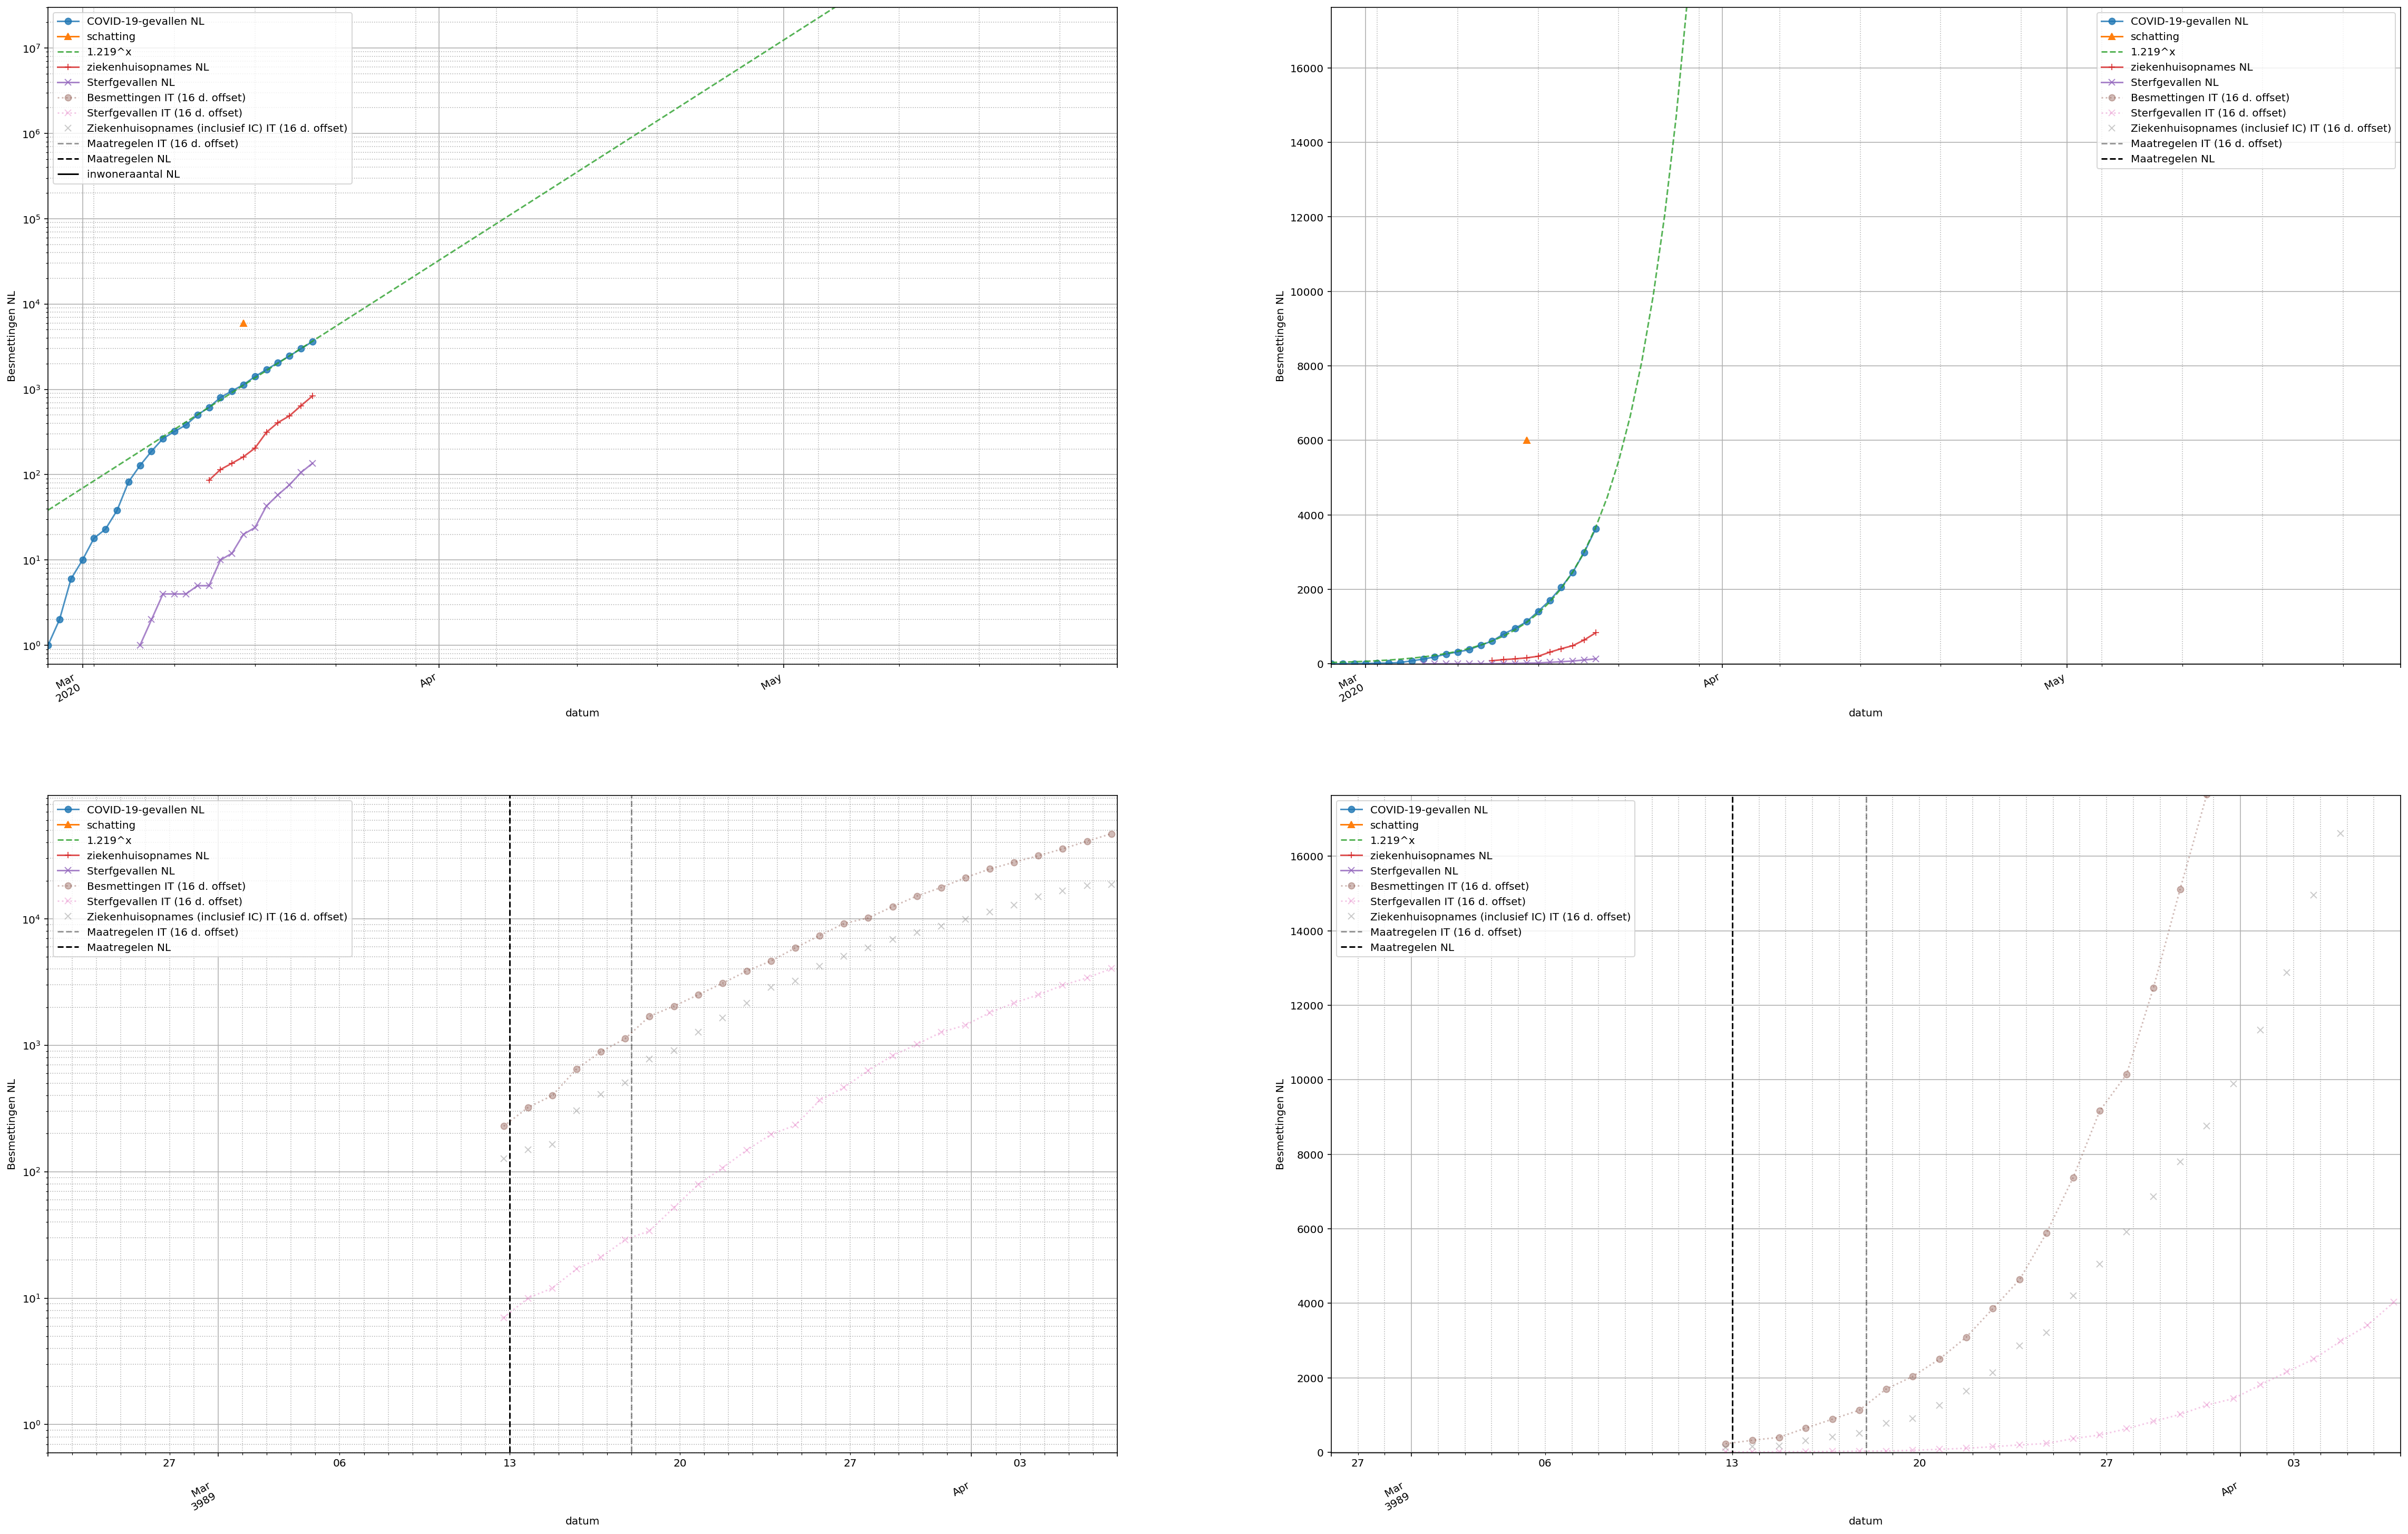

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(40, 28))

for ax_ in ax.flatten():
    besmettingen.plot(label="COVID-19-gevallen NL", marker="o", alpha=0.8, ax=ax_)
    schattingen.plot(marker="^", ax=ax_)
    y_pred_exp.plot(label=f"{b.round(3)}^x", alpha=0.8, style="--", ax=ax_)
    #     y_pred_logistic.plot(
    #         label=f"logistische functie (conv. -> {L.round(1)})", style=":", ax=ax_
    #     )
    #     y_pred_iedereen.plot(
    #         label=f"logistische functie (conv. -> 17.4e6", style=":", ax=ax_
    #     )
    ziekenhuisopnames.plot(label="ziekenhuisopnames NL", marker="+", alpha=0.8, ax=ax_)
    sterfgevallen.plot(label="Sterfgevallen NL", marker="x", alpha=0.8, ax=ax_)
    italie_besmet.shift(offset).plot(
        label=f"Besmettingen IT ({offset} d. offset)",
        marker="o",
        style=":",
        alpha=0.4,
        ax=ax_,
    )
    italie_sterf.shift(offset).plot(
        label=f"Sterfgevallen IT ({offset} d. offset)",
        marker="x",
        style=":",
        alpha=0.4,
        ax=ax_,
    )
    (italie_ic + italie_ziekenhuis).shift(offset).plot(
        label=f"Ziekenhuisopnames (inclusief IC) IT ({offset} d. offset)",
        marker="x",
        style="+",
        alpha=0.4,
        ax=ax_,
    )
    ax_.vlines(
        [pd.to_datetime("2020-03-01") + pd.to_timedelta(offset, "D")],
        -1e3,
        1e8,
        label=f"Maatregelen IT ({offset} d. offset)",
        linestyle="--",
        alpha=0.4,
    )
    ax_.vlines(
        ["2020-03-12"], -1e3, 1e8, label="Maatregelen NL", linestyle="--",
    )

for ax_ in ax[:, 0]:
    ax_.set_yscale("log")
ax[0, 0].set_ylim([0.6, 3e7])
ax[0, 0].hlines(17.4e6, date.index.min(), date.index.max(), label="inwoneraantal NL")


ax[1, 0].set_ylim([0.6, italie_besmet.max() * 2])
ax[1, 0].set_xlim("02-22-2020", besmettingen.index.max() + pd.to_timedelta(offset, "D"))
# ax[1, 0].legend(loc=2)


ax[0, 1].set_ylim([-10, L * 1.2])

ax[1, 1].set_xlim("02-26-2020", besmettingen.index.max() + pd.to_timedelta(offset, "D"))
ax[1, 1].set_ylim([-10, L * 1.2])

for ax_ in ax.flatten():
    ax_.legend()
    ax_.grid(which="minor", linestyle=(":"))
    ax_.grid(which="major")
    ax_.set_xlabel("datum")
    ax_.set_ylabel("Besmettingen NL")

plt.show()

R squared for the fits:

In [45]:
pd.concat(
    [
        besmettingen.rename("actual numbers"),
        y_pred_logistic.rename("logistic"),
        y_pred_exp.rename("exponential fit"),
    ],
    axis=1,
).corr() ** 2

actual numbers  logistic  exponential fit
actual numbers         1.000000  0.998870         0.997995
logistic               0.998870  1.000000         0.060066
exponential fit        0.997995  0.060066         1.000000

New cases:

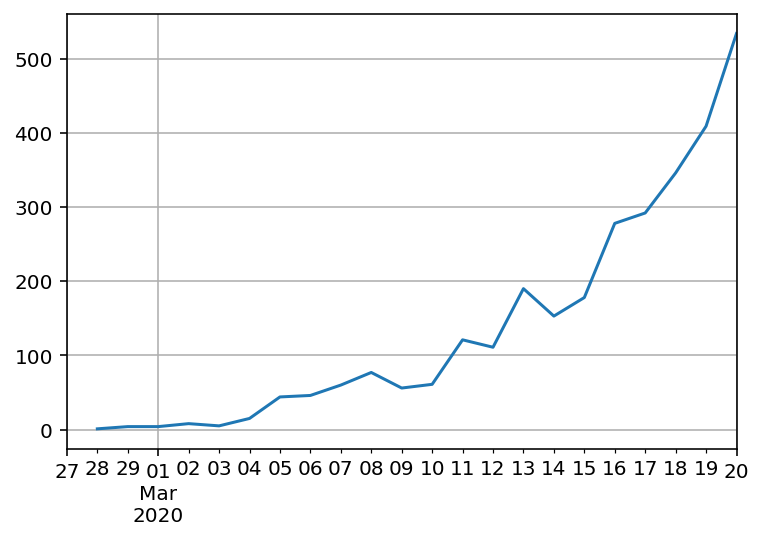

In [8]:
besmettingen.diff().plot()
plt.grid()
plt.show()

Ratio between new cases from day to day:

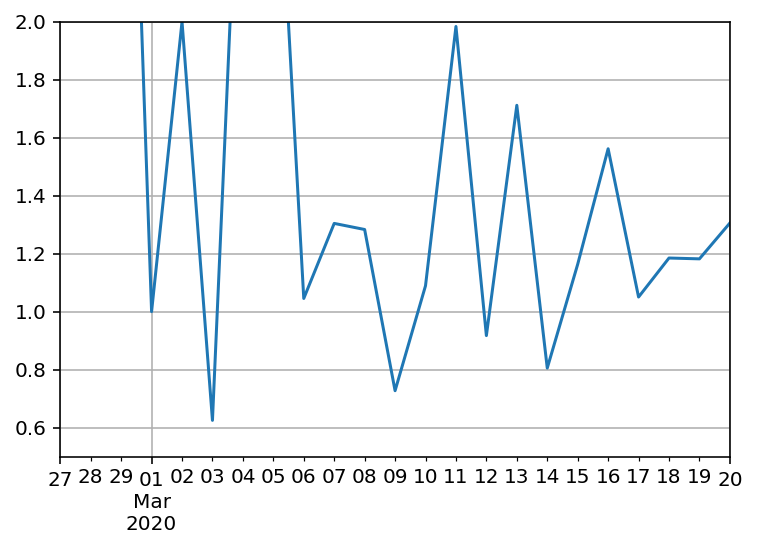

In [9]:
(besmettingen.diff() / besmettingen.diff().shift()).plot()
plt.ylim([0.5, 2])
plt.grid()
plt.show()

In [ ]:
(besmettingen.diff() / besmettingen.diff().shift()).plot(marker="o")
(ziekenhuisopnames.diff() / ziekenhuisopnames.diff().shift()).plot(marker="+")
(sterfgevallen.diff() / sterfgevallen.diff().shift()).plot(marker="x")
plt.ylim([0, 3])
plt.xlim([None, besmettingen.index.max() + pd.to_timedelta(2, "d")])
plt.legend()
plt.grid()
plt.show()